In [1]:
import pandas as pd
import scipy as sp
from tqdm import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys, os, copy
from pathlib import Path
import os

THIS_PATH = Path(os.path.abspath(''))
DATA_PATH = THIS_PATH.parent / "data"   # TODO: turn this into a snippet!

In [2]:
import gir
import gir.config as gc
from gir.dataset.panel_data import PanelData, REFERENCE
from gir.dataset.grid import Grid
from gir.ml.preprocess import get_panel_names, plane_id_list
from gir.config import DATA_PATH as GIR_DATA_PATH

sys.path = [str(THIS_PATH.parent.absolute())] + sys.path
from utils.gird import get_panel_surface

fs = 96e3
# TODO: Make this a snippet for this project!

In [3]:
panel_names = []

with Path(DATA_PATH / "panel_names.txt").open() as f:
    for line in f:
        panel_names.append(line.strip())

print(panel_names)

['mean_flat_cg', 'mean_flat_rfl_1', 'mean_flat_rfl_2', 'mean_flat_vj_fu', 'mean_flat_vj_ph', 'panel_0001_0', 'panel_0001_1', 'panel_0002_1', 'panel_0003_0', 'panel_0003_1', 'panel_0004_0', 'panel_0004_1', 'panel_0005_0', 'panel_0005_1', 'panel_0006_0', 'panel_0006_1', 'panel_0007_0', 'panel_0007_1', 'panel_0008_0', 'panel_0008_1', 'panel_0009_0', 'panel_0009_1', 'panel_0010_0', 'panel_0010_1', 'panel_0011_0', 'panel_0011_1', 'panel_0012_0', 'panel_0012_1', 'panel_0013_0', 'panel_0013_1', 'panel_0014_1', 'panel_0015_0', 'panel_0015_1', 'panel_0016_0', 'panel_0016_1', 'panel_0016_r180_0', 'panel_0017_0', 'panel_0017_1', 'panel_0018_0', 'panel_0018_1', 'panel_0019_0', 'panel_0019_1', 'panel_0020_0', 'panel_0020_1', 'panel_0021_0', 'panel_0021_1', 'panel_0022_0', 'panel_0022_1', 'panel_0023_0', 'panel_0023_1', 'panel_0024_0', 'panel_0024_1', 'panel_0025_0', 'panel_0025_1', 'panel_0026_0', 'panel_0026_1', 'panel_0027_0', 'panel_0027_1', 'panel_0028_0', 'panel_0028_1', 'panel_0029_0', 'panel

In [4]:
combs_df = pd.read_hdf(DATA_PATH / "combinations_df.h5", key="df")
combs_df = combs_df.sort_values('combination', ascending=True)
combs_df.tail()

,combination,mic cell,spkr cell,angle,dp dly (geo),echo dly (bz),echo dly (tz),echo dly (gpy),spkr emit angle,mic rec angle,surf inc angle,dp echo diff
2946,2947,"[2, 2, 0]","[3, 0, 0]",15.35,72.964529,230.638597,208.970481,209.368811,34.0,115.0,15.0,146.840009
2947,2948,"[2, 3, 0]","[3, 0, 0]",20.22,88.157712,235.885824,214.747809,215.404605,37.0,102.0,20.0,137.159105
2948,2949,"[2, 3, 1]","[3, 0, 0]",15.35,72.964529,230.638597,208.970481,209.368811,34.0,115.0,15.0,146.840009
2949,2950,"[2, 3, 2]","[3, 0, 0]",15.35,72.964529,230.638597,208.970481,209.368811,34.0,115.0,15.0,146.840009
2950,2951,"[2, 3, 3]","[3, 0, 0]",20.22,88.157712,235.885824,214.747809,215.404605,37.0,102.0,20.0,137.159105


In [5]:
combs_vwb_df = combs_df[combs_df['dp echo diff'] > 55]
len(combs_vwb_df)

1065

## Emitter, Receiver Angles Histograms

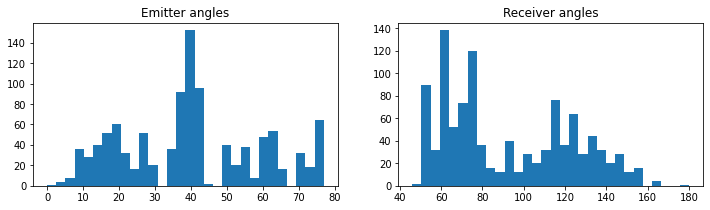

In [6]:
le_angles, mr_angles = combs_vwb_df[['spkr emit angle', 'mic rec angle']].values.T
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].hist(le_angles, bins=30)
axs[0].set_title('Emitter angles')
axs[1].hist(mr_angles, bins=30)
axs[1].set_title('Receiver angles')
plt.show()

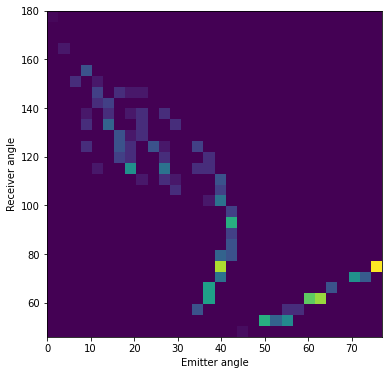

In [7]:
# make a 2d histogram of the emitter and receiver angles
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist2d(le_angles, mr_angles, bins=30)
ax.set_xlabel('Emitter angle')
ax.set_ylabel('Receiver angle')
plt.show()

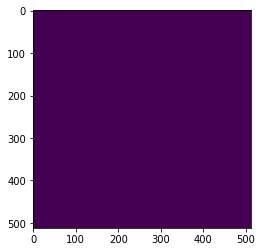

In [8]:
panel = PanelData(panel_names[3])
panel_surface = get_panel_surface(panel)
plt.imshow(panel_surface)

In [9]:
from scipy.signal import find_peaks
from typing import Tuple, List

# def two_largest_peaks(ir, width=None, rel_prominence=5e-2) -> np.ndarray:
#     irmaxval = ir.max()
#     peaks, peakprops = find_peaks(ir, width=width,
#                                   prominence=rel_prominence*irmaxval)
#     if len(peaks) < 2:
#         raise Exception("Not enough peaks found")
#     peaks = peaks[np.argsort(peakprops['prominences'])[-2:]]
#     return peaks

# def dp_and_echo_peak(ir, dp0, echo0):
#     imv = ir.max()
#     peaks, props = find_peaks(ir, prominence=1e-3*imv)
#     g = peaks - dp0


# def get_dp_ir(ir: np.ndarray, win: Tuple[int, int]) -> np.ndarray:
#     dp_peak, echo_peak = np.sort(two_largest_peaks(ir))
#     return ir[dp_peak-win[0]:dp_peak+win[1]]

# def get_dp_echo_irs(ir: np.ndarray, win: Tuple[int, int]) -> Tuple[np.ndarray, np.ndarray]:
#     dp_peak, echo_peak = np.sort(two_largest_peaks(ir))
#     dp_ir = ir[dp_peak-win[0]:dp_peak+win[1]]
#     echo_ir = ir[echo_peak-win[0]:echo_peak+win[1]]
#     return dp_ir, echo_ir

def major_peak(signal, rel_prominence=5e-3):
    peaks, props = find_peaks(signal, prominence=rel_prominence*signal.max())
    majorpeak = peaks[np.argsort(props['prominences'])[-1]]
    return majorpeak

gaussian_filters = [
    np.array((1, 2, 1)) / 4,
    np.array((1, 4, 6, 4, 1)) / 16,
    np.array((1, 6, 15, 20, 15, 6, 1)) / 64,
    np.array((1, 8, 28, 56, 70, 56, 28, 8, 1)) / 256,
]

def major_peak_by_smoothing(signal, rel_prominence=5e-3, num_filters=1):
    assert 0 < num_filters <= len(gaussian_filters), "num_filters must be in range 1-4"

    peak_ests = [major_peak(signal)]
    for i in range(num_filters):
        smoothed_signal = np.convolve(signal, gaussian_filters[i], mode='same')
        peak_ests.append(major_peak(signal))

    return np.median(peak_ests).astype(int)

def dp_and_echo_peak(ir, dp0, echo_lower, echo_upper, num_filters=1):
    """Returns position of direct path and echo path peaks in ir.

    Args:
        ir (np.ndarray): The IR signal.
        dp0 (int): Initial guess of direct path peak position, in samples, strictly an integer.
        echo_lower (int): Lower bound of echo peak, in samples, strictly an integer.
        echo_upper (int): Upper bound of echo peak, in samples, strictly an integer.
    """
    dpsnip = ir[dp0-8:dp0+20]
    dppeak = dp0 - 8 + major_peak_by_smoothing(dpsnip, num_filters)
    echosnip = ir[echo_lower-5:echo_upper+5]
    echopeak = echo_lower - 5 + major_peak_by_smoothing(echosnip, num_filters)

    return dppeak, echopeak

def peak_guesses_from_combination(comb, combs_df):
    """Returns direct path dly, echo dly lower and upper bounds from combination as a tuple."""
    row = combs_df[combs_df['combination'] == comb]
    return row[['dp dly (geo)', 'echo dly (tz)', 'echo dly (bz)']].values[0].astype(int)

def get_dp_echo_irs(ir, comb, win: Tuple[int, int], num_filters=2) -> Tuple[np.ndarray, np.ndarray]:
    dp0, echo_lower, echo_upper = peak_guesses_from_combination(comb, combs_df)
    dp_peak, echo_peak = dp_and_echo_peak(ir, dp0, echo_lower, echo_upper, num_filters)
    dp_ir = ir[dp_peak-win[0]:dp_peak+win[1]]
    echo_ir = ir[echo_peak-win[0]:echo_peak+win[1]]
    return dp_ir, echo_ir

In [10]:
dpirs = []
echoirs = []
fullirs = []
failedcombs = []
for c in combs_vwb_df['combination']:
    ir = panel.impulse_response_from_combination(c)
    dpir, echoir = get_dp_echo_irs(ir, c, (8, 50))
    dpir = dpir / dpir[8]
    echoir = echoir / echoir[8]
    dpirs.append(dpir)
    echoirs.append(echoir)
    fullirs.append(ir)

dpirs = np.array(dpirs)
echoirs = np.array(echoirs)
fullirs = np.array(fullirs)
dpirs.shape, fullirs.shape

((1065, 58), (1065, 400))

In [23]:
%matplotlib inline
from ipywidgets import IntSlider, interact, widgets, Layout
from IPython.display import display
from matplotlib.lines import Line2D

sortedidx = np.argsort(le_angles)

def what():
    xdatasnip = np.arange(-8, 50, 1)
    xdatafull = np.arange(400)
    combs = combs_vwb_df['combination'].values

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    lines: List[Line2D] = [axs[i].plot([], [])[0] for i in range(3)]
    for ax in axs[:2]:
        ax.set_xlim(-8, 50)
        ax.grid(True)
        ax.vlines(0, -1, 1, color='k', linestyle='--')
    axs[0].set_ylim(dpirs.min(), dpirs.max())
    axs[1].set_ylim(echoirs.min(), echoirs.max())
    axs[2].set_ylim(fullirs.min(), fullirs.max())
    axs[2].set_xlim(0, 400)
    fig.tight_layout()
    plt.close()

    slider = IntSlider(min=0, max=len(combs_vwb_df)-1, step=1, value=0,
                       layout=Layout(width='800px'))

    @interact(index = slider)
    def update(index):
        si = sortedidx[index]
        c = combs[si]
        lines[0].set_data(xdatasnip, dpirs[si])
        lines[1].set_data(xdatasnip, echoirs[si])
        lines[2].set_data(xdatafull, fullirs[si])
        axs[0].set_title(f'Emisson angle = {le_angles[si]:.1f}°')
        axs[1].set_title(f'Reception angle = {mr_angles[si]:.1f}°')

        display(fig)
        print(f'Combination num \t = {c}')

what()

interactive(children=(IntSlider(value=0, description='index', layout=Layout(width='800px'), max=1064), Output(…

## Trying Regression

In [24]:
# do a basic general linear model fit using statsmodels
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
# the independent variables are the emission and receiver angles
# the dependent variable is the direct path impulse response (dpir) vector

# Assuming `endog` is a DataFrame of your dependent variables
# and `exog` is a DataFrame of your independent variables

X = np.column_stack((le_angles, mr_angles))
# X[X > 160] = np.nan
# X = np.tan(np.deg2rad(X)/2)
X = sm.add_constant(X)

all_results = []
coeffs = []
for i in range(dpirs.shape[1]):
    y = dpirs[:, i]
    model = sm.OLS(y, X, missing='drop')
    results = model.fit()
    all_results.append(results)
    coeffs.append(results.params)

coeffs = np.array(coeffs)


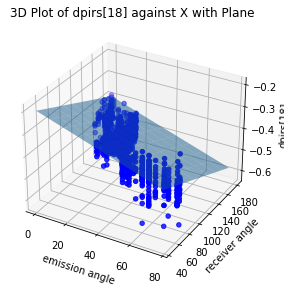

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     54.91
Date:                Thu, 07 Mar 2024   Prob (F-statistic):           2.02e-23
Time:                        14:20:02   Log-Likelihood:                 4829.6
No. Observations:                1065   AIC:                            -9653.
Df Residuals:                    1062   BIC:                            -9638.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.001      8.870      0.0

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
samp = 18
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(X[:, 1], X[:, 2], dpirs[:, samp], c='b', marker='o')

# Create a meshgrid for the plane
x = np.linspace(min(X[:, 1]), max(X[:, 1]), 10)
y = np.linspace(min(X[:, 2]), max(X[:, 2]), 10)
X_plane, Y_plane = np.meshgrid(x, y)

# Calculate the Z values for the plane using the coefficients
Z_plane = coeffs[samp, 0] + coeffs[samp, 1] * X_plane + coeffs[samp, 2] * Y_plane

# Plot the plane
ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.5)

# Set labels and title
ax.set_xlabel('emission angle')
ax.set_ylabel('receiver angle')
ax.set_zlabel(f'dpirs[{samp}]')
ax.set_title(f'3D Plot of dpirs[{samp}] against X with Plane')

# Show the plot
plt.tight_layout()
plt.show()
print(all_results[0].summary())

## One angle pair

In [38]:
combs_df.head(3)

,combination,mic cell,spkr cell,angle,dp dly (geo),echo dly (bz),echo dly (tz),echo dly (gpy),spkr emit angle,mic rec angle,surf inc angle,dp echo diff
0,1,"[0, 0, 0]","[0, 0, 1]",21.54,20.991254,78.429796,57.170934,57.170934,68.0,68.0,22.0,46.809111
1,2,"[0, 0, 0]","[0, 0, 2]",38.29,41.982507,86.447273,67.752593,67.752593,52.0,52.0,38.0,35.117426
2,3,"[0, 0, 0]","[0, 0, 3]",49.82,62.973761,98.368159,82.423161,82.423161,40.0,40.0,50.0,27.421899


In [60]:
groups = combs_vwb_df.groupby([combs_vwb_df['spkr emit angle'], combs_vwb_df['mic rec angle']])
groups = sorted(groups, key=lambda x: len(x[1]), reverse=True)
# print group lengths
print([len(g[1]) for g in groups])

[54, 48, 40, 40, 32, 32, 30, 24, 20, 18, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1]


In [104]:
%matplotlib qt

grp_idx = 0  # Replace 0 with the desired index
selected_group = groups[grp_idx]
sel_spkr_angle, sel_mic_angle = selected_group[0]

for c in selected_group[1]['combination']:
    ir = panel.impulse_response_from_combination(c)
    dpir, echoir = get_dp_echo_irs(ir, c, (8, 50))
    dpir = dpir / dpir[8]
    # echoir = echoir / echoir[8]
    # plt.stem(dpir, linefmt=':', markerfmt='o')
    # plot dpir with marker colour blue, line colour green
    plt.plot(dpir, color='gray', linestyle=':', alpha=0.16, marker=None)
    plt.scatter(np.arange(len(dpir)), dpir, color='g', alpha=0.25, marker='.')

plt.title(f'spkr angle = {sel_spkr_angle}, mic angle = {sel_mic_angle}: {len(selected_group[1])} combinations')
plt.show()

In [51]:
type(row)

pandas.core.frame.Pandas

In [37]:
# Print the sorted groups
for group_name, group_data in groups:
    print(f"Group Name: {group_name}")
    print(f"Group Size: {len(group_data)}")
    print()


Group Name: (63.0, 63.0)
Group Size: 54

Group Name: (60.0, 60.0)
Group Size: 48

Group Name: (51.0, 51.0)
Group Size: 40

Group Name: (76.0, 76.0)
Group Size: 40

Group Name: (37.0, 64.0)
Group Size: 32

Group Name: (70.0, 70.0)
Group Size: 32

Group Name: (54.0, 54.0)
Group Size: 30

Group Name: (77.0, 77.0)
Group Size: 24

Group Name: (53.0, 53.0)
Group Size: 20

Group Name: (72.0, 72.0)
Group Size: 18

Group Name: (16.0, 127.0)
Group Size: 16

Group Name: (28.0, 115.0)
Group Size: 16

Group Name: (40.0, 74.0)
Group Size: 16

Group Name: (41.0, 76.0)
Group Size: 16

Group Name: (41.0, 101.0)
Group Size: 16

Group Name: (42.0, 81.0)
Group Size: 16

Group Name: (42.0, 91.0)
Group Size: 16

Group Name: (42.0, 93.0)
Group Size: 16

Group Name: (66.0, 66.0)
Group Size: 16

Group Name: (6.0, 149.0)
Group Size: 8

Group Name: (8.0, 157.0)
Group Size: 8

Group Name: (9.0, 132.0)
Group Size: 8

Group Name: (9.0, 154.0)
Group Size: 8

Group Name: (10.0, 126.0)
Group Size: 8

Group Name: (11.0